In [14]:
import sys
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns


if ".." not in sys.path:
    sys.path.append("..")

from utils.const import (
    ALL_VARS,
    INTEREST_VARS,
    VARIABLE_COLORS,
    ALL_ZONES,
    CLEANED_DATASETS_PATH,
    SELECTED_ZONES,
)
from utils.plotting import (
    plot_series,
    box_plot,
    hist_plot,
    data_exploration,
)
from utils.stats import (
    print_variable_info,
    describe_variables,
    filter_final_data,
)

from utils.preprocessing import (
    mfill,
    date_fill,
)

from utils.transform import (
    yeo_johnson_transformation,
    log_transformation,
)
import matplotlib.pyplot as plt

## Leer Datos Limpios

In [15]:
# Se crea un diccionario donde se contengan todos los df de zonas elegidas
cleaned_df: dict[str, pd.DataFrame] = dict()

for zone_path in CLEANED_DATASETS_PATH:
    zone = zone_path.split("/")[-1].split(".")[0].split("_")[0]

    cleaned_df.update({zone: pd.read_csv(zone_path, parse_dates=["date"])})

cleaned_df["CENTRO"]

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2020-01-01 00:00:00,3.22,3.2,6.5,9.8,19.0,86.34,60.910000,713.6,0.0,91.0,2.9,0.000,10.49,3.7,2.0
1,2020-01-01 01:00:00,3.22,3.2,6.5,9.8,19.0,112.01,63.975000,713.6,0.0,91.0,2.9,0.158,10.49,3.7,2.0
2,2020-01-01 02:00:00,3.22,3.2,5.6,8.8,18.0,100.01,65.507500,712.8,0.0,91.0,2.9,0.156,10.51,1.9,144.0
3,2020-01-01 03:00:00,3.22,3.2,7.2,10.4,14.0,106.20,66.273750,712.4,0.0,92.0,2.9,0.158,10.64,2.7,28.0
4,2020-01-01 04:00:00,3.26,4.7,10.6,15.3,5.0,141.86,66.656875,712.0,0.0,92.0,3.3,0.163,10.73,2.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,2023-08-17 19:00:00,0.57,3.6,10.8,14.6,37.0,48.00,13.260000,708.9,0.0,19.0,3.5,0.030,36.24,15.1,68.0
31796,2023-08-17 20:00:00,0.59,2.9,14.0,17.1,31.0,44.00,11.990000,709.3,0.0,21.0,2.6,0.002,35.08,13.2,80.0
31797,2023-08-17 21:00:00,0.61,2.7,15.7,18.6,26.0,47.00,13.260000,709.8,0.0,22.0,2.5,0.000,34.23,8.7,100.0
31798,2023-08-17 22:00:00,0.62,2.5,11.9,14.7,28.0,48.00,11.720000,710.2,0.0,25.0,2.4,0.000,33.61,8.8,111.0


## Agrupamiento DIARIO

In [16]:
# Se crea un diccionario donde se contengan todos los df de zonas elegidas
grouped_dfs: dict[str, pd.DataFrame] = dict()

for zone, df in cleaned_df.items():
    df_ = df.copy()
    df_ = df_.groupby(pd.Grouper(key="date", freq="1D")).mean().reset_index()
    grouped_dfs.update({zone: df_})

del df_

grouped_dfs["CENTRO"]

,date,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WSR,WDR
0,2020-01-01,3.147083,4.116667,6.650000,10.775000,15.625000,65.090833,36.904824,711.254167,0.0,89.125000,2.679167,0.153333,12.279583,2.466667,189.958333
1,2020-01-02,3.245000,8.412500,9.229167,17.637500,19.166667,37.528750,9.342083,705.408333,0.0,62.083333,2.881250,0.168708,16.812917,3.762500,201.500000
2,2020-01-03,2.916250,4.558333,6.325000,10.883333,32.791667,37.939583,8.061667,711.533333,0.0,35.291667,3.633333,0.166542,17.174583,9.812500,260.666667
3,2020-01-04,3.024583,5.670833,9.579167,15.245833,25.750000,47.499583,16.165833,719.620833,0.0,39.166667,3.914583,0.172625,14.604583,3.679167,179.958333
4,2020-01-05,3.157500,5.025000,12.058333,17.033333,25.828125,62.838333,27.457500,718.254167,0.0,40.083333,7.656250,0.175208,15.855417,3.662500,183.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,2023-08-13,0.414167,3.658333,6.512500,10.387500,29.375000,45.041667,12.966667,710.433333,0.0,43.125000,2.087500,0.283208,31.052083,11.570833,64.708333
1321,2023-08-14,0.462083,4.733333,6.866667,11.816667,25.541667,49.208333,13.393333,711.454167,0.0,50.541667,1.983333,0.228000,30.116250,11.745833,81.166667
1322,2023-08-15,0.496667,5.404167,8.300000,13.945833,24.500000,47.833333,13.322500,712.833333,0.0,49.000000,2.200000,0.247760,29.815417,10.370833,72.416667
1323,2023-08-16,0.572500,6.075000,10.329167,16.645833,25.958333,61.166667,18.605417,711.666667,0.0,39.083333,2.933333,0.276146,31.083333,9.875000,71.583333


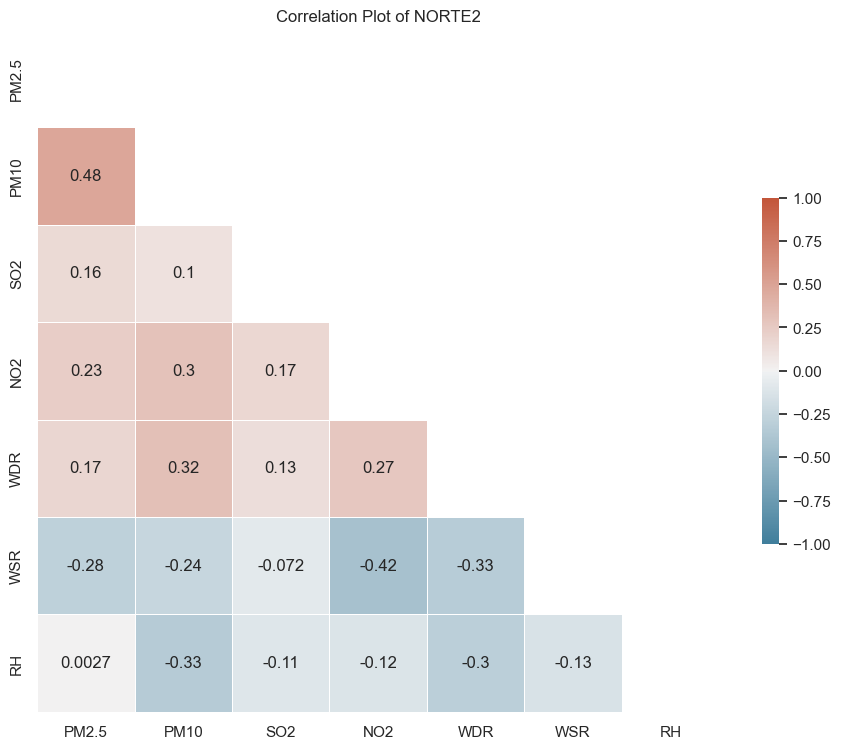

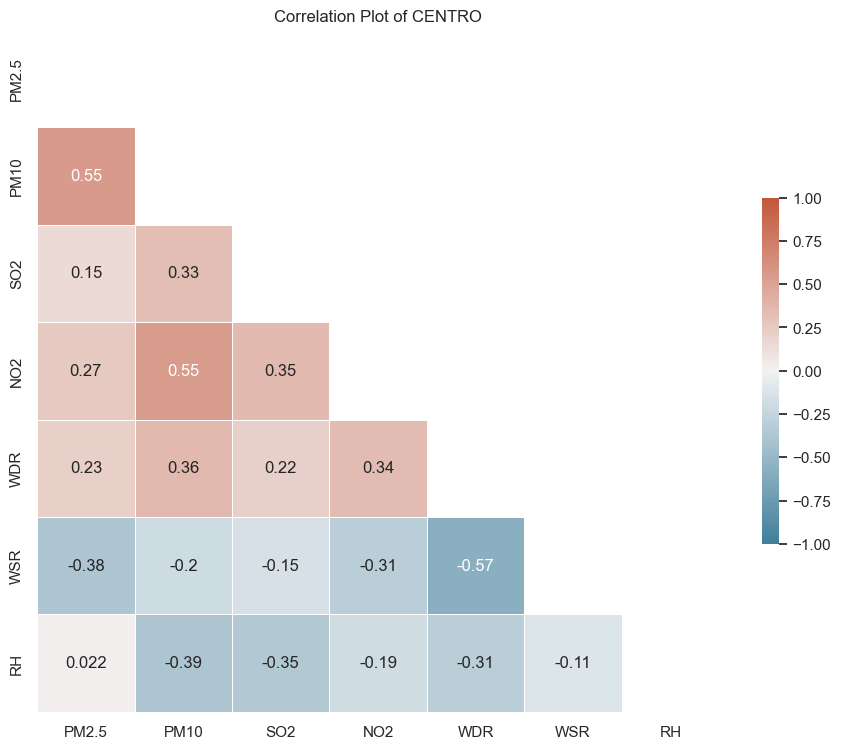

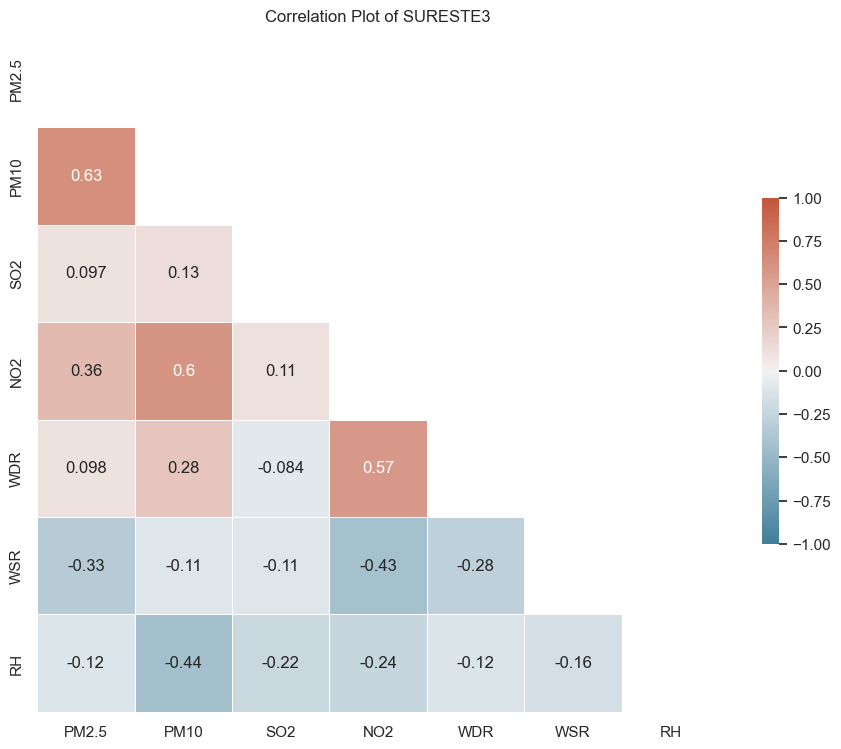

In [17]:
# Corr Plot of zones CENTRO, NORTE2, and SURESTE3, with variables PM10, PM2.5, WDR, RH, WSR, SO2, NO2, using hex.
sns.set_theme(style="white")
for zone in SELECTED_ZONES:
    df = grouped_dfs[zone]
    df = df[INTEREST_VARS]
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
    )
    plt.title(f"Correlation Plot of {zone}")
    plt.show()

C:\Users\Franco Mendoza\AppData\Local\Temp\ipykernel_22696\2314479627.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day"] = df["date"].dt.day_name()
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Franco Mendoza\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', Tru

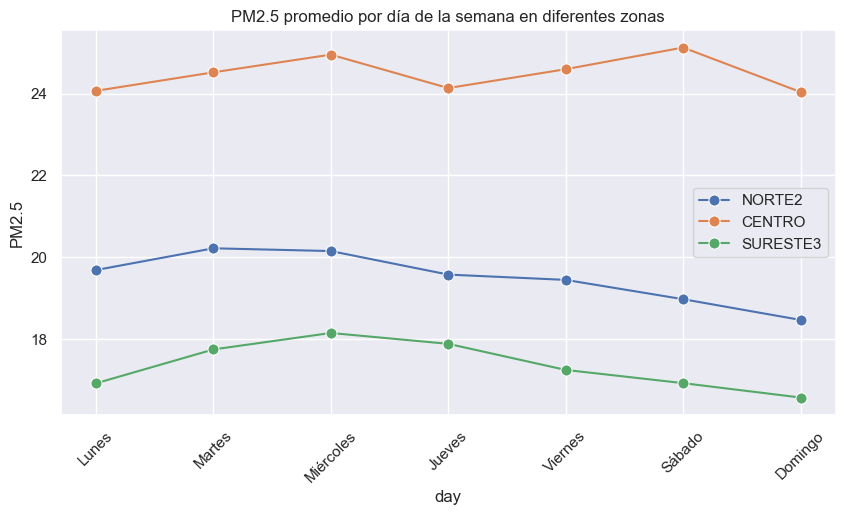

In [26]:
# Graph of average PM2.5 per each day of the week, for each zone.
sns.set_theme()
english_to_spanish = {
    "Monday": "Lunes",
    "Tuesday": "Martes",
    "Wednesday": "Miércoles",
    "Thursday": "Jueves",
    "Friday": "Viernes",
    "Saturday": "Sábado",
    "Sunday": "Domingo",
}

spanish_days = [
    "Lunes",
    "Martes",
    "Miércoles",
    "Jueves",
    "Viernes",
    "Sábado",
    "Domingo",
]

plt.figure(figsize=(10, 5))

for zone in SELECTED_ZONES:
    df = grouped_dfs[zone]
    df = df[["date", "PM2.5"]]
    df["day"] = df["date"].dt.day_name()
    df = df.groupby("day").mean().reset_index()
    
    df["day"] = df["day"].map(english_to_spanish)
    df["day"] = pd.Categorical(df["day"], categories=spanish_days, ordered=True)
    df = df.sort_values("day")
    
    sns.lineplot(data=df, x="day", y="PM2.5", marker="o", markersize=8, label=zone)  

plt.title("PM2.5 promedio por día de la semana en diferentes zonas")
plt.xticks(rotation=45)  
plt.grid(True) 
plt.legend()
plt.show()

del df

In [ ]:
# # Se convierten a csv todos los df del diccionario grouped_dfs, y se guarden en la carpeta datos/03_grouped_datasets
# for zone, df in grouped_dfs.items():
#     df.to_csv(f"../../datos/03_grouped_datasets/{zone}_2020_2023.csv", index=False)